In [ ]:
# 8 классов препаратов:
# ингибиторы АПФ, блокаторы рецепторов к ангиотензину 2, бета-блокаторы,
# барбитураты, гистаминовые блокаторы, фибраты, бензодиазепины,
# блокаторы кальциевых каналов производные дигидроперидина.

In [1]:
import os
import numpy as np
import pandas as pd
import ast
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import seaborn as sns

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 48.5 MB/s eta 0:00:00


In [3]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, Convolution2D, BatchNormalization
from tensorflow.keras.layers import ReLU, MaxPool2D, AvgPool2D, GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
import threading

Данные получены при помощи Drug Bank https://go.drugbank.com/releases/latest

In [4]:
# Считаем датасет.

df_sm = pd.read_csv('new_data_db')

df_sm.head()

,drugname,drug_type,groups,codes,smiles,atc_4
0,Bivalirudin,small molecule,"['approved', 'investigational']","['Direct thrombin inhibitors', 'ANTITHROMBOTIC...",CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,Direct thrombin inhibitors
1,Leuprolide,small molecule,"['approved', 'investigational']","['Gonadotropin releasing hormone analogues', '...",CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,Gonadotropin releasing hormone analogues
2,Goserelin,small molecule,['approved'],"['Gonadotropin releasing hormone analogues', '...",CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,Gonadotropin releasing hormone analogues
3,Gramicidin D,small molecule,['approved'],"['Antibiotics', 'THROAT PREPARATIONS', 'THROAT...",CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,Antibiotics
4,Desmopressin,small molecule,['approved'],"['Vasopressin and analogues', 'POSTERIOR PITUI...",NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,Vasopressin and analogues


In [5]:
# Размер всего датасета.

df_sm.shape

(12227, 6)

In [6]:
# У многих препаратов отсутствует кодировка по ATC.
# Часто такие препараты не содержат описания, описания мишеней действия.

df_sm[df_sm['codes']=='[]'].shape

(9203, 6)

Анатомо-терапевтическо-химическая классификация (АТХ, ATC) — это международная медицинская унификация, которая распределяет лекарственные препараты по группам и состоит из 5 уровней.
Для разделения на классы будет использован 4 уровень классификации: терапевтические фармакологические основные химические лекарственные средства.


In [7]:
# Посчитаем, сколько препаратов с различными кодировками ATC_4 есть всего.
# У некоторых препаратов могут быть 2 ATC кодировки, с одинаковыми ATC_4.

atc_4_list = []

for i in df_sm['codes']:
    for j in ast.literal_eval(i):
        if j[-1].islower():
            atc_4_list.append(j)

In [8]:
atc_4_series = pd.Series(atc_4_list)

pd.set_option('display.max_rows', None)

atc_4_series.value_counts()

Sulfonamides                                                                                       75
Antibiotics                                                                                        73
Antivirals for treatment of HIV infections, combinations                                           71
Progestogens and estrogens, fixed combinations                                                     68
Combinations of oral blood glucose lowering drugs                                                  54
Combinations for eradication of Helicobacter pylori                                                49
Lipid modifying agents in combination with other drugs                                             44
Progestogens and estrogens, sequential preparations                                                42
Benzodiazepine derivatives                                                                         40
Corticosteroids                                                                   

Далее для модели будут использованы основные классы препаратов, применяемые в терапии (ингибиторы АПФ, блокаторы рецепторов к ангиотензину 2, бета-блокаторы, барбитураты, гистаминовые блокаторы, фибраты, бензодиазепины, блокаторы кальциевых каналов произвоные дигидроперидина).
Для использования в датасет не входят комбинации препаратов, препараты без определенной химической группы ("Others...").

In [9]:
# Датасет для ингибиторов АПФ.

ingib_ace_df = df_sm[df_sm['codes'].str.contains('ACE inhibitors, plain')]

In [10]:
ingib_ace_df.shape

(16, 6)

In [11]:
ingib_ace_df['p_np'] = 'ingib_ace'

ingib_ace_df.head()

<ipython-input-11-a7f915a1d9ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ingib_ace_df['p_np'] = 'ingib_ace'


,drugname,drug_type,groups,codes,smiles,atc_4,p_np
72,Ramipril,small molecule,['approved'],"['ACE inhibitors, other combinations', 'ACE IN...",[H][C@@]12CCC[C@]1([H])N([C@@H](C2)C(O)=O)C(=O...,"ACE inhibitors, other combinations",ingib_ace
384,Fosinopril,small molecule,['approved'],"['ACE inhibitors and diuretics', 'ACE INHIBITO...",CCC(=O)O[C@@H](OP(=O)(CCCCC1=CC=CC=C1)CC(=O)N1...,ACE inhibitors and diuretics,ingib_ace
409,Trandolapril,small molecule,['approved'],"['ACE inhibitors, plain', 'ACE INHIBITORS, PLA...",[H][C@@]12C[C@H](N(C(=O)[C@H](C)N[C@@H](CCC3=C...,"ACE inhibitors, plain",ingib_ace
432,Benazepril,small molecule,"['approved', 'investigational']","['ACE inhibitors and diuretics', 'ACE INHIBITO...",[H][C@@]1(CCC2=CC=CC=C2N(CC(O)=O)C1=O)N[C@@H](...,ACE inhibitors and diuretics,ingib_ace
474,Enalapril,small molecule,"['approved', 'vet_approved']","['ACE inhibitors and diuretics', 'ACE INHIBITO...",CCOC(=O)[C@H](CCC1=CC=CC=C1)N[C@@H](C)C(=O)N1C...,ACE inhibitors and diuretics,ingib_ace


In [12]:
# Датасет для бета-блокаторов (селективных и неселективных).

beta_block_df = df_sm[df_sm['codes'].str.contains('Beta blocking agents, non-selective') | df_sm['codes'].str.contains('Beta blocking agents, selective')]

In [13]:
beta_block_df.shape

(29, 6)

In [14]:
beta_block_df['p_np'] = 'beta_block'

beta_block_df.head()

<ipython-input-14-3e112878177e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_block_df['p_np'] = 'beta_block'


,drugname,drug_type,groups,codes,smiles,atc_4,p_np
81,Esmolol,small molecule,"['approved', 'withdrawn']","['Beta blocking agents, selective', 'BETA BLOC...",COC(=O)CCC1=CC=C(OCC(O)CNC(C)C)C=C1,"Beta blocking agents, selective",beta_block
89,Betaxolol,small molecule,"['approved', 'investigational']","['Beta blocking agents', 'ANTIGLAUCOMA PREPARA...",CC(C)NCC(O)COC1=CC=C(CCOCC2CC2)C=C1,Beta blocking agents,beta_block
158,Metoprolol,small molecule,"['approved', 'investigational']",['Beta blocking agents and calcium channel blo...,COCCC1=CC=C(OCC(O)CNC(C)C)C=C1,Beta blocking agents and calcium channel blockers,beta_block
228,Atenolol,small molecule,['approved'],"['Beta blocking agents, selective, and other d...",CC(C)NCC(O)COC1=CC=C(CC(N)=O)C=C1,"Beta blocking agents, selective, and other diu...",beta_block
266,Timolol,small molecule,['approved'],"['Beta blocking agents, non-selective', 'BETA ...",[H][C@](O)(CNC(C)(C)C)COC1=NSN=C1N1CCOCC1,"Beta blocking agents, non-selective",beta_block


In [15]:
# Датасет для барбитуратов.

barbit_df = df_sm[df_sm['codes'].str.contains('Barbiturates, plain')]

barbit_df.shape

(17, 6)

In [16]:
barbit_df['p_np'] = 'barbiturat'

barbit_df.head()

<ipython-input-16-e55dd61a026d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barbit_df['p_np'] = 'barbiturat'


,drugname,drug_type,groups,codes,smiles,atc_4,p_np
200,Talbutal,small molecule,"['approved', 'illicit']","['Barbiturates, plain', 'HYPNOTICS AND SEDATIV...",CCC(C)C1(CC=C)C(=O)NC(=O)NC1=O,"Barbiturates, plain",barbiturat
206,Pentobarbital,small molecule,"['approved', 'investigational', 'vet_approved']","['Barbiturates, combinations', 'HYPNOTICS AND ...",CCCC(C)C1(CC)C(=O)NC(=O)NC1=O,"Barbiturates, combinations",barbiturat
310,Secobarbital,small molecule,"['approved', 'vet_approved']","['Barbiturates, combinations', 'HYPNOTICS AND ...",CCCC(C)C1(CC=C)C(=O)NC(=O)NC1=O,"Barbiturates, combinations",barbiturat
366,Methohexital,small molecule,['approved'],"['Barbiturates, combinations', 'HYPNOTICS AND ...",CCC#CC(C)C1(CC=C)C(=O)NC(=O)N(C)C1=O,"Barbiturates, combinations",barbiturat
489,Thiopental,small molecule,"['approved', 'vet_approved']","['Barbiturates, plain', 'ANESTHETICS, GENERAL'...",CCCC(C)C1(CC)C(=O)NC(=S)NC1=O,"Barbiturates, plain",barbiturat


In [85]:
# Датасет для блокаторов кальциевых каналов.
# Взяты только производные дигидроперидина, как самый большой класс среди этой группы.

ca_chan_block_dihidro_df = df_sm[df_sm['codes'].str.contains('Dihydropyridine derivatives')]
ca_chan_block_dihidro_df = ca_chan_block_dihidro_df.drop([374]) # Удален Celecoxib, т.к. относится к противовоспалительным.

ca_chan_block_dihidro_df.head()

,drugname,drug_type,groups,codes,smiles,atc_4
164,Isradipine,small molecule,"['approved', 'investigational']","['Dihydropyridine derivatives', 'SELECTIVE CAL...",COC(=O)C1=C(C)NC(C)=C(C1C1=CC=CC2=NON=C12)C(=O...,Dihydropyridine derivatives
274,Amlodipine,small molecule,['approved'],"['Renin-inhibitors', 'OTHER AGENTS ACTING ON T...",CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,Renin-inhibitors
285,Nimodipine,small molecule,"['approved', 'investigational']","['Dihydropyridine derivatives', 'SELECTIVE CAL...",COCCOC(=O)C1=C(C)NC(C)=C(C1C1=CC(=CC=C1)[N+]([...,Dihydropyridine derivatives
293,Nisoldipine,small molecule,['approved'],"['Dihydropyridine derivatives', 'SELECTIVE CAL...",COC(=O)C1=C(C)NC(C)=C(C1C1=CC=CC=C1[N+]([O-])=...,Dihydropyridine derivatives
418,Lercanidipine,small molecule,"['approved', 'investigational']",['Angiotensin II receptor blockers (ARBs) and ...,COC(=O)C1=C(C)NC(C)=C(C1C1=CC(=CC=C1)[N+]([O-]...,Angiotensin II receptor blockers (ARBs) and ca...


In [18]:
ca_chan_block_dihidro_df.shape

(17, 6)

In [19]:
ca_chan_block_dihidro_df['p_np'] = 'ca_chan_block_dihidro'

ca_chan_block_dihidro_df.head()

,drugname,drug_type,groups,codes,smiles,atc_4,p_np
164,Isradipine,small molecule,"['approved', 'investigational']","['Dihydropyridine derivatives', 'SELECTIVE CAL...",COC(=O)C1=C(C)NC(C)=C(C1C1=CC=CC2=NON=C12)C(=O...,Dihydropyridine derivatives,ca_chan_block_dihidro
274,Amlodipine,small molecule,['approved'],"['Renin-inhibitors', 'OTHER AGENTS ACTING ON T...",CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,Renin-inhibitors,ca_chan_block_dihidro
285,Nimodipine,small molecule,"['approved', 'investigational']","['Dihydropyridine derivatives', 'SELECTIVE CAL...",COCCOC(=O)C1=C(C)NC(C)=C(C1C1=CC(=CC=C1)[N+]([...,Dihydropyridine derivatives,ca_chan_block_dihidro
293,Nisoldipine,small molecule,['approved'],"['Dihydropyridine derivatives', 'SELECTIVE CAL...",COC(=O)C1=C(C)NC(C)=C(C1C1=CC=CC=C1[N+]([O-])=...,Dihydropyridine derivatives,ca_chan_block_dihidro
418,Lercanidipine,small molecule,"['approved', 'investigational']",['Angiotensin II receptor blockers (ARBs) and ...,COC(=O)C1=C(C)NC(C)=C(C1C1=CC(=CC=C1)[N+]([O-]...,Angiotensin II receptor blockers (ARBs) and ca...,ca_chan_block_dihidro


In [20]:
# Датасет для блокаторов рецепторов к ангиотензину 2.

sartan_df = df_sm[df_sm['codes'].str.contains('ARBs') & df_sm['codes'].str.contains('plain')]
sartan_df = sartan_df.drop([885]) # Удален гидрохлортиазид, т.к. относится к другой группе.

In [21]:
sartan_df.shape

(10, 6)

In [22]:
sartan_df['p_np'] = 'ARBs'

sartan_df.head()

,drugname,drug_type,groups,codes,smiles,atc_4,p_np
71,Valsartan,small molecule,"['approved', 'investigational']","['Angiotensin II receptor blockers (ARBs), oth...",CCCCC(=O)N(CC1=CC=C(C=C1)C1=CC=CC=C1C1=NNN=N1)...,"Angiotensin II receptor blockers (ARBs), other...",ARBs
169,Olmesartan,small molecule,"['approved', 'investigational']",['Angiotensin II receptor blockers (ARBs) and ...,CCCC1=NC(=C(N1CC1=CC=C(C=C1)C1=C(C=CC=C1)C1=NN...,Angiotensin II receptor blockers (ARBs) and di...,ARBs
566,Losartan,small molecule,['approved'],"['Angiotensin II receptor blockers (ARBs), pla...",CCCCC1=NC(Cl)=C(CO)N1CC1=CC=C(C=C1)C1=CC=CC=C1...,"Angiotensin II receptor blockers (ARBs), plain",ARBs
762,Eprosartan,small molecule,['approved'],['Angiotensin II receptor blockers (ARBs) and ...,CCCCC1=NC=C(\C=C(/CC2=CC=CS2)C(O)=O)N1CC1=CC=C...,Angiotensin II receptor blockers (ARBs) and di...,ARBs
852,Telmisartan,small molecule,"['approved', 'investigational']",['Angiotensin II receptor blockers (ARBs) and ...,CCCC1=NC2=C(C=C(C=C2C)C2=NC3=CC=CC=C3N2C)N1CC1...,Angiotensin II receptor blockers (ARBs) and ca...,ARBs


In [23]:
# Датасет для бензодиазепинов.

benzodiazepin_df = df_sm[df_sm['codes'].str.contains('Benzodiazepine derivatives')]

In [24]:
benzodiazepin_df.shape

(39, 6)

In [25]:
benzodiazepin_df['p_np'] = 'benzodiazepin'

benzodiazepin_df.head()

<ipython-input-25-98870928ce40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benzodiazepin_df['p_np'] = 'benzodiazepin'


,drugname,drug_type,groups,codes,smiles,atc_4,p_np
80,Lorazepam,small molecule,['approved'],"['Benzodiazepine derivatives', 'ANXIOLYTICS', ...",OC1N=C(C2=CC=CC=C2Cl)C2=C(NC1=O)C=CC(Cl)=C2,Benzodiazepine derivatives,benzodiazepin
125,Temazepam,small molecule,"['approved', 'investigational']","['Benzodiazepine derivatives', 'HYPNOTICS AND ...",CN1C2=C(C=C(Cl)C=C2)C(=NC(O)C1=O)C1=CC=CC=C1,Benzodiazepine derivatives,benzodiazepin
242,Clobazam,small molecule,"['approved', 'illicit']","['Benzodiazepine derivatives', 'ANXIOLYTICS', ...",CN1C2=C(C=C(Cl)C=C2)N(C2=CC=CC=C2)C(=O)CC1=O,Benzodiazepine derivatives,benzodiazepin
296,Alprazolam,small molecule,"['approved', 'illicit', 'investigational']","['Benzodiazepine derivatives', 'ANXIOLYTICS', ...",CC1=NN=C2CN=C(C3=CC=CC=C3)C3=C(C=CC(Cl)=C3)N12,Benzodiazepine derivatives,benzodiazepin
367,Chlordiazepoxide,small molecule,"['approved', 'illicit', 'investigational']","['Benzodiazepine derivatives', 'ANXIOLYTICS', ...",CNC1=NC2=C(C=C(Cl)C=C2)C(C2=CC=CC=C2)=[N+]([O-...,Benzodiazepine derivatives,benzodiazepin


In [26]:
# Aminoalkyl ethers?
# Датасет для антигистминных препаратов.
# Взяты две подгруппы схожие химически.

anti_hist_df = df_sm[df_sm['codes'].str.contains('Substituted alkylamines') | df_sm['codes'].str.contains('Substituted ethylene diamines')]

In [27]:
anti_hist_df.shape

(13, 6)

In [28]:
anti_hist_df

,drugname,drug_type,groups,codes,smiles,atc_4
297,Dexbrompheniramine,small molecule,['approved'],"['Substituted alkylamines', 'ANTIHISTAMINES FO...",CN(C)CC[C@@H](C1=CC=C(Br)C=C1)C1=CC=CC=N1,Substituted alkylamines
678,Tripelennamine,small molecule,"['approved', 'vet_approved']","['Substituted ethylene diamines', 'ANTIHISTAMI...",CN(C)CCN(CC1=CC=CC=C1)C1=CC=CC=N1,Substituted ethylene diamines
721,Brompheniramine,small molecule,['approved'],"['Substituted alkylamines', 'ANTIHISTAMINES FO...",CN(C)CCC(C1=CC=C(Br)C=C1)C1=CC=CC=N1,Substituted alkylamines
997,Chlorpheniramine,small molecule,['approved'],"['Substituted alkylamines', 'ANTIHISTAMINES FO...",CN(C)CCC(C1=CC=C(Cl)C=C1)C1=CC=CC=N1,Substituted alkylamines
1432,Pheniramine,small molecule,['approved'],"['Substituted alkylamines', 'ANTIHISTAMINES FO...",CN(C)CCC(C1=CC=CC=C1)C1=CC=CC=N1,Substituted alkylamines
4417,Methapyrilene,small molecule,['withdrawn'],"['Substituted ethylene diamines', 'ANTIHISTAMI...",CN(C)CCN(CC1=CC=CS1)C1=NC=CC=C1,Substituted ethylene diamines
5430,Mepyramine,small molecule,"['approved', 'vet_approved']","['Antihistamines for topical use', 'ANTIPRURIT...",COC1=CC=C(CN(CCN(C)C)C2=NC=CC=C2)C=C1,Antihistamines for topical use
7448,Chloropyramine,small molecule,['experimental'],"['Antihistamines for topical use', 'ANTIPRURIT...",CN(C)CCN(CC1=CC=C(Cl)C=C1)C1=CC=CC=N1,Antihistamines for topical use
7449,Dimetindene,small molecule,"['approved', 'investigational']","['Substituted alkylamines', 'ANTIHISTAMINES FO...",CC(C1=C(CCN(C)C)CC2=CC=CC=C12)C1=CC=CC=N1,Substituted alkylamines
8140,Thonzylamine,small molecule,['approved'],"['Antihistamines for topical use', 'ANTIPRURIT...",COC1=CC=C(CN(CCN(C)C)C2=NC=CC=N2)C=C1,Antihistamines for topical use


In [29]:
anti_hist_df['p_np'] = 'anti_hist'

anti_hist_df.head()

<ipython-input-29-d8b000b861b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anti_hist_df['p_np'] = 'anti_hist'


,drugname,drug_type,groups,codes,smiles,atc_4,p_np
297,Dexbrompheniramine,small molecule,['approved'],"['Substituted alkylamines', 'ANTIHISTAMINES FO...",CN(C)CC[C@@H](C1=CC=C(Br)C=C1)C1=CC=CC=N1,Substituted alkylamines,anti_hist
678,Tripelennamine,small molecule,"['approved', 'vet_approved']","['Substituted ethylene diamines', 'ANTIHISTAMI...",CN(C)CCN(CC1=CC=CC=C1)C1=CC=CC=N1,Substituted ethylene diamines,anti_hist
721,Brompheniramine,small molecule,['approved'],"['Substituted alkylamines', 'ANTIHISTAMINES FO...",CN(C)CCC(C1=CC=C(Br)C=C1)C1=CC=CC=N1,Substituted alkylamines,anti_hist
997,Chlorpheniramine,small molecule,['approved'],"['Substituted alkylamines', 'ANTIHISTAMINES FO...",CN(C)CCC(C1=CC=C(Cl)C=C1)C1=CC=CC=N1,Substituted alkylamines,anti_hist
1432,Pheniramine,small molecule,['approved'],"['Substituted alkylamines', 'ANTIHISTAMINES FO...",CN(C)CCC(C1=CC=CC=C1)C1=CC=CC=N1,Substituted alkylamines,anti_hist


In [30]:
# Датасет для фибратов.

fibrat_df = df_sm[df_sm['codes'].str.contains('Fibrates')]

fibrat_df.shape

(11, 6)

In [31]:
fibrat_df

,drugname,drug_type,groups,codes,smiles,atc_4
526,Clofibrate,small molecule,"['approved', 'investigational']","['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CCOC(=O)C(C)(C)OC1=CC=C(Cl)C=C1,Fibrates
924,Fenofibrate,small molecule,['approved'],['Combinations of various lipid modifying agen...,CC(C)OC(=O)C(C)(C)OC1=CC=C(C=C1)C(=O)C1=CC=C(C...,Combinations of various lipid modifying agents
1124,Gemfibrozil,small molecule,['approved'],"['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CC1=CC(OCCCC(C)(C)C(O)=O)=C(C)C=C1,Fibrates
1221,Bezafibrate,small molecule,"['approved', 'investigational']","['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CC(C)(OC1=CC=C(CCNC(=O)C2=CC=C(Cl)C=C2)C=C1)C(...,Fibrates
7597,Etofibrate,small molecule,['experimental'],"['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CC(C)(OC1=CC=C(Cl)C=C1)C(=O)OCCOC(=O)C1=CN=CC=C1,Fibrates
7661,Ciprofibrate,small molecule,"['approved', 'investigational']","['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CC(C)(OC1=CC=C(C=C1)C1CC1(Cl)Cl)C(O)=O,Fibrates
9940,Simfibrate,small molecule,['experimental'],"['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CC(C)(OC1=CC=C(Cl)C=C1)C(=O)OCCCOC(=O)C(C)(C)O...,Fibrates
9965,Ronifibrate,small molecule,['experimental'],"['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CC(C)(OC1=CC=C(Cl)C=C1)C(=O)OCCCOC(=O)C1=CN=CC=C1,Fibrates
10275,Aluminium clofibrate,small molecule,['experimental'],"['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",[OH-].[Al+3].CC(C)(OC1=CC=C(Cl)C=C1)C([O-])=O....,Fibrates
10344,Clofibride,small molecule,['experimental'],"['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CN(C)C(=O)CCCOC(=O)C(C)(C)OC1=CC=C(Cl)C=C1,Fibrates


In [32]:
fibrat_df['p_np'] = 'fibrat'

fibrat_df.head()

<ipython-input-32-f0ca4b491343>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fibrat_df['p_np'] = 'fibrat'


,drugname,drug_type,groups,codes,smiles,atc_4,p_np
526,Clofibrate,small molecule,"['approved', 'investigational']","['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CCOC(=O)C(C)(C)OC1=CC=C(Cl)C=C1,Fibrates,fibrat
924,Fenofibrate,small molecule,['approved'],['Combinations of various lipid modifying agen...,CC(C)OC(=O)C(C)(C)OC1=CC=C(C=C1)C(=O)C1=CC=C(C...,Combinations of various lipid modifying agents,fibrat
1124,Gemfibrozil,small molecule,['approved'],"['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CC1=CC(OCCCC(C)(C)C(O)=O)=C(C)C=C1,Fibrates,fibrat
1221,Bezafibrate,small molecule,"['approved', 'investigational']","['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CC(C)(OC1=CC=C(CCNC(=O)C2=CC=C(Cl)C=C2)C=C1)C(...,Fibrates,fibrat
7597,Etofibrate,small molecule,['experimental'],"['Fibrates', 'LIPID MODIFYING AGENTS, PLAIN', ...",CC(C)(OC1=CC=C(Cl)C=C1)C(=O)OCCOC(=O)C1=CN=CC=C1,Fibrates,fibrat


In [33]:
# Собираем в общий датасет.

df_red = pd.concat([beta_block_df, ingib_ace_df, barbit_df,
                    ca_chan_block_dihidro_df, benzodiazepin_df,
                    sartan_df, anti_hist_df, fibrat_df], ignore_index=True)

df_red.head()

,drugname,drug_type,groups,codes,smiles,atc_4,p_np
0,Esmolol,small molecule,"['approved', 'withdrawn']","['Beta blocking agents, selective', 'BETA BLOC...",COC(=O)CCC1=CC=C(OCC(O)CNC(C)C)C=C1,"Beta blocking agents, selective",beta_block
1,Betaxolol,small molecule,"['approved', 'investigational']","['Beta blocking agents', 'ANTIGLAUCOMA PREPARA...",CC(C)NCC(O)COC1=CC=C(CCOCC2CC2)C=C1,Beta blocking agents,beta_block
2,Metoprolol,small molecule,"['approved', 'investigational']",['Beta blocking agents and calcium channel blo...,COCCC1=CC=C(OCC(O)CNC(C)C)C=C1,Beta blocking agents and calcium channel blockers,beta_block
3,Atenolol,small molecule,['approved'],"['Beta blocking agents, selective, and other d...",CC(C)NCC(O)COC1=CC=C(CC(N)=O)C=C1,"Beta blocking agents, selective, and other diu...",beta_block
4,Timolol,small molecule,['approved'],"['Beta blocking agents, non-selective', 'BETA ...",[H][C@](O)(CNC(C)(C)C)COC1=NSN=C1N1CCOCC1,"Beta blocking agents, non-selective",beta_block


In [34]:
df_red.shape

(152, 7)

In [ ]:
# Классы получаются весьма малочисленными.

df_red['p_np'].value_counts()

benzodiazepin            39
beta_block               29
barbiturat               17
ca_chan_block_dihidro    17
ingib_ace                16
anti_hist                13
fibrat                   11
ARBs                     10
Name: p_np, dtype: int64

In [35]:
# Заменим названия классов на числовые кодировки.

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df_red['p_np'] = le.fit_transform(df_red['p_np'])

df_red.head()

,drugname,drug_type,groups,codes,smiles,atc_4,p_np
0,Esmolol,small molecule,"['approved', 'withdrawn']","['Beta blocking agents, selective', 'BETA BLOC...",COC(=O)CCC1=CC=C(OCC(O)CNC(C)C)C=C1,"Beta blocking agents, selective",4
1,Betaxolol,small molecule,"['approved', 'investigational']","['Beta blocking agents', 'ANTIGLAUCOMA PREPARA...",CC(C)NCC(O)COC1=CC=C(CCOCC2CC2)C=C1,Beta blocking agents,4
2,Metoprolol,small molecule,"['approved', 'investigational']",['Beta blocking agents and calcium channel blo...,COCCC1=CC=C(OCC(O)CNC(C)C)C=C1,Beta blocking agents and calcium channel blockers,4
3,Atenolol,small molecule,['approved'],"['Beta blocking agents, selective, and other d...",CC(C)NCC(O)COC1=CC=C(CC(N)=O)C=C1,"Beta blocking agents, selective, and other diu...",4
4,Timolol,small molecule,['approved'],"['Beta blocking agents, non-selective', 'BETA ...",[H][C@](O)(CNC(C)(C)C)COC1=NSN=C1N1CCOCC1,"Beta blocking agents, non-selective",4


In [36]:
df_red['p_np'].value_counts()

3    39
4    29
2    17
5    17
7    16
1    13
6    11
0    10
Name: p_np, dtype: int64

In [38]:
# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

In [39]:
# Далее выберем из данных SMILES и целевую переменную p_np.

X = df_red['smiles']
y = df_red['p_np']

In [40]:
# Сразу разделим и отложим тестовую и валидационную выборки.

x_train, x_test, y_train, y_test = train_test_split(
        X, y,stratify=y, test_size=0.2)

x_test, x_valid, y_test, y_valid = train_test_split(
        x_test, y_test, stratify=y_test, test_size=0.5)

In [41]:
# Выделим отдельно тренировочный датасет, понадобится для дальнейших преобразований.

train_dataset = pd.DataFrame({'smiles': x_train, 'p_np': y_train})

train_dataset.head()

,smiles,p_np
45,CCC(C)C1(CC=C)C(=O)NC(=O)NC1=O,2
95,CN1C2=C(C=C(C=C2)[N+]([O-])=O)C(=NCC1=O)C1=CC=...,3
84,CN(C)CC1=NN=C2CN=C(C3=CC=CC=C3)C3=C(C=CC(Cl)=C...,3
86,CC1=NC=C2CN=C(C3=CC=CC=C3F)C3=C(C=CC(Cl)=C3)N12,3
38,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,7


Так как данные малочисленные, понадобится аугментация.
Подход к аугментации заимствован из https://arxiv.org/abs/1703.07076, https://github.com/EBjerrum/SMILES-enumeration/blob/master/SmilesEnumerator.py

In [43]:
class SmilesEnumerator(object):
    """SMILES Enumerator, vectorizer and devectorizer

    #Arguments
        charset: string containing the characters for the vectorization
          can also be generated via the .fit() method
        pad: Length of the vectorization
        leftpad: Add spaces to the left of the SMILES
        isomericSmiles: Generate SMILES containing information about stereogenic centers
        enum: Enumerate the SMILES during transform
        canonical: use canonical SMILES during transform (overrides enum)
    """
    def __init__(self, charset = '@C)(=cOn1S2/H[N]\\', pad=120, leftpad=True, isomericSmiles=True, enum=True, canonical=False):
        self._charset = None
        self.charset = charset
        self.pad = pad
        self.leftpad = leftpad
        self.isomericSmiles = isomericSmiles
        self.enumerate = enum
        self.canonical = canonical

    @property
    def charset(self):
        return self._charset

    @charset.setter
    def charset(self, charset):
        self._charset = charset
        self._charlen = len(charset)
        self._char_to_int = dict((c,i) for i,c in enumerate(charset))
        self._int_to_char = dict((i,c) for i,c in enumerate(charset))

    def fit(self, smiles, extra_chars=[], extra_pad = 5):
        """Performs extraction of the charset and length of a SMILES datasets and sets self.pad and self.charset

        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
            extra_chars: List of extra chars to add to the charset (e.g. "\\\\" when "/" is present)
            extra_pad: Extra padding to add before or after the SMILES vectorization
        """
        charset = set("".join(list(smiles)))
        self.charset = "".join(charset.union(set(extra_chars)))
        self.pad = max([len(smile) for smile in smiles]) + extra_pad

    def randomize_smiles(self, smiles):
        """Perform a randomization of a SMILES string
        must be RDKit sanitizable"""
        m = Chem.MolFromSmiles(smiles)
        ans = list(range(m.GetNumAtoms()))
        np.random.shuffle(ans)
        nm = Chem.RenumberAtoms(m,ans)
        return Chem.MolToSmiles(nm, canonical=self.canonical, isomericSmiles=self.isomericSmiles)

    def transform(self, smiles):
        """Perform an enumeration (randomization) and vectorization of a Numpy array of smiles strings
        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
        """
        one_hot =  np.zeros((smiles.shape[0], self.pad, self._charlen),dtype=np.int8)

        if self.leftpad:
            for i,ss in enumerate(smiles):
                if self.enumerate: ss = self.randomize_smiles(ss)
                l = len(ss)
                diff = self.pad - l
                for j,c in enumerate(ss):
                    one_hot[i,j+diff,self._char_to_int[c]] = 1
            return one_hot
        else:
            for i,ss in enumerate(smiles):
                if self.enumerate: ss = self.randomize_smiles(ss)
                for j,c in enumerate(ss):
                    one_hot[i,j,self._char_to_int[c]] = 1
            return one_hot


    def reverse_transform(self, vect):
        """ Performs a conversion of a vectorized SMILES to a smiles strings
        charset must be the same as used for vectorization.
        #Arguments
            vect: Numpy array of vectorized SMILES.
        """
        smiles = []
        for v in vect:
            #mask v
            v=v[v.sum(axis=1)==1]
            #Find one hot encoded index with argmax, translate to char and join to string
            smile = "".join(self._int_to_char[i] for i in v.argmax(axis=1))
            smiles.append(smile)
        return np.array(smiles)

In [44]:
# Функция для аугментации.

def augmentation(dataset, num_classes, augmentation_number):

    sme = SmilesEnumerator()

    df_list = []

    for i in range(num_classes):
        d = dataset[dataset['p_np']==i]

        train_smiles = []

        for smiles in d['smiles']:
            for _ in range(augmentation_number):
                train_smiles.append(sme.randomize_smiles(smiles))

        t_d = pd.DataFrame({'smiles': train_smiles, 'p_np': i})

        exec(f'dataset_{i} = t_d')
        exec(f'df_list.append(dataset_{i})')

    fin_dataset = pd.concat(df_list)

    return (fin_dataset)

In [45]:
# Выполним аугментацию для тренировочного датасета.
# Каждый класс увеличивается в 15 раз.

train_data = augmentation(train_dataset, 8, 15)

In [46]:
train_data.shape

(1815, 2)

In [47]:
# Перемешаем тренировочную выборку.

train_data = train_data.sample(frac=1)

In [48]:
# Снова разделяем на X и y.

x_train = train_data['smiles']

y_train = train_data['p_np']

Для реализации MPNN будет использован код из туториала https://keras.io/examples/graph/mpnn-molecular-graphs/

In [49]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


In [50]:
def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )



In [51]:
x_train = graphs_from_smiles(x_train)

x_valid = graphs_from_smiles(x_valid)

x_test = graphs_from_smiles(x_test)

In [52]:
def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)


In [53]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


In [54]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)


In [96]:
from tensorflow.keras.backend import clear_session

clear_session()

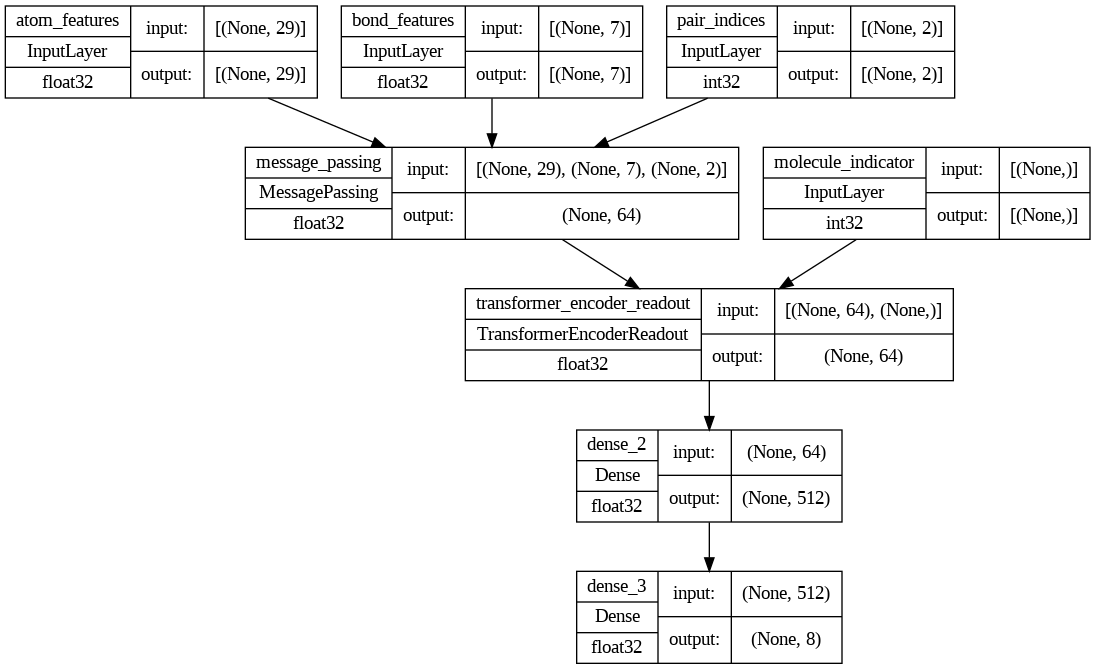

In [97]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=64,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(8, activation="softmax")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

In [98]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

In [99]:
history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    verbose=2
)

Epoch 1/10
57/57 - 33s - loss: 1.3058 - accuracy: 0.6149 - val_loss: 0.7950 - val_accuracy: 0.8125 - 33s/epoch - 578ms/step
Epoch 2/10
57/57 - 25s - loss: 0.5628 - accuracy: 0.9107 - val_loss: 0.3659 - val_accuracy: 0.8750 - 25s/epoch - 432ms/step
Epoch 3/10
57/57 - 24s - loss: 0.2578 - accuracy: 0.9857 - val_loss: 0.1678 - val_accuracy: 1.0000 - 24s/epoch - 412ms/step
Epoch 4/10
57/57 - 24s - loss: 0.1243 - accuracy: 0.9956 - val_loss: 0.0940 - val_accuracy: 1.0000 - 24s/epoch - 426ms/step
Epoch 5/10
57/57 - 22s - loss: 0.0680 - accuracy: 0.9994 - val_loss: 0.0615 - val_accuracy: 1.0000 - 22s/epoch - 393ms/step
Epoch 6/10
57/57 - 24s - loss: 0.0403 - accuracy: 1.0000 - val_loss: 0.0502 - val_accuracy: 1.0000 - 24s/epoch - 428ms/step
Epoch 7/10
57/57 - 26s - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.0403 - val_accuracy: 1.0000 - 26s/epoch - 460ms/step
Epoch 8/10
57/57 - 25s - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 1.0000 - 25s/epoch - 440ms/step
Epoch 9/

In [100]:
y_pred = mpnn.predict(test_dataset)
y_pred

1/1 [==============================] - 1s 1s/step


array([[2.05631251e-04, 1.43802856e-04, 2.32119473e-05, 7.22191271e-06,
        9.98726308e-01, 6.86469502e-05, 9.14548800e-05, 7.33693247e-04],
       [3.71674323e-05, 1.75565612e-04, 9.97162402e-01, 2.13372230e-04,
        3.06975271e-05, 1.21108617e-03, 1.68055354e-04, 1.00158073e-03],
       [2.35067564e-04, 5.73646757e-05, 2.40791705e-04, 9.99190629e-01,
        2.37828608e-05, 1.88323262e-04, 5.66955459e-05, 7.30912825e-06],
       [5.86295247e-01, 5.04880678e-03, 1.11328426e-03, 4.59147245e-03,
        4.43228288e-03, 3.59554529e-01, 4.77841403e-03, 3.41859870e-02],
       [1.14333304e-03, 9.94364858e-01, 1.97054978e-04, 3.13230383e-04,
        3.09714163e-03, 2.50935227e-05, 5.61215798e-04, 2.98120431e-04],
       [2.51072831e-03, 9.56941210e-03, 8.57716799e-01, 1.62441395e-02,
        1.67313090e-03, 1.54024009e-02, 4.76753190e-02, 4.92079668e-02],
       [1.69537714e-04, 2.62917893e-04, 2.24664054e-05, 4.54622477e-06,
        9.97944891e-01, 3.91109534e-05, 8.28476404e-05, 1.

In [101]:
y_pred = np.argmax(y_pred, axis=1)

y_pred

array([4, 2, 3, 0, 1, 2, 4, 3, 4, 2, 5, 6, 7, 3, 3])

In [102]:
# Метрики на тестовой выборке.

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      0.50      0.67         2

    accuracy                           0.93        15
   macro avg       0.96      0.94      0.93        15
weighted avg       0.96      0.93      0.93        15



In [103]:
y_pred_val = mpnn.predict(valid_dataset)
y_pred_val= np.argmax(y_pred_val, axis=1)

1/1 [==============================] - 0s 258ms/step


In [104]:
# Метрики на валидационной выборке.

print(classification_report(y_valid, y_pred_val))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



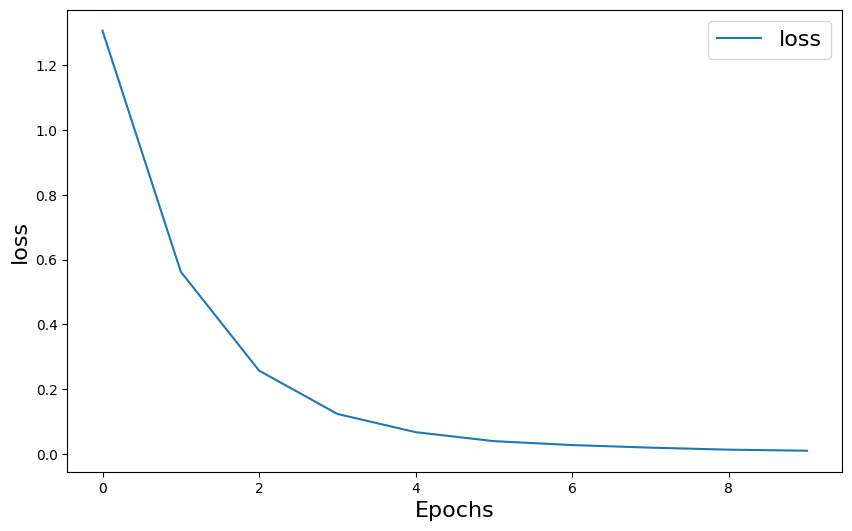

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="loss")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.legend(fontsize=16)

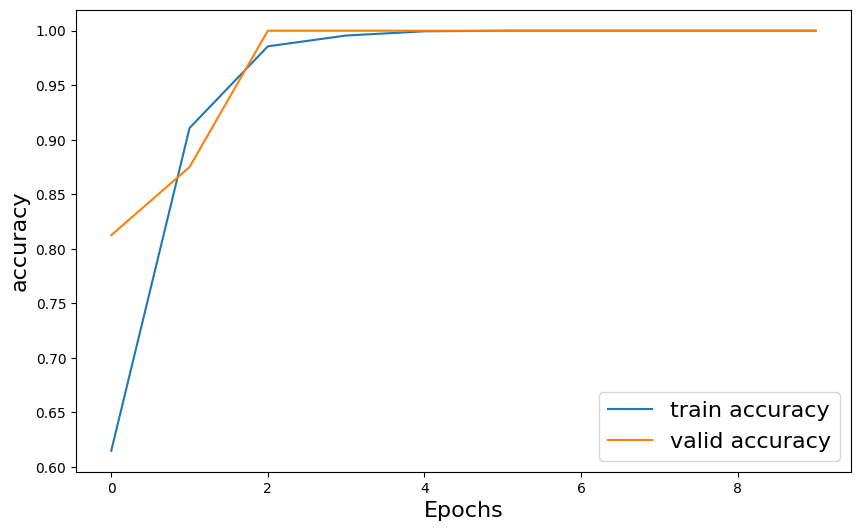

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="valid accuracy")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.legend(fontsize=16)

In [107]:
print("MIN Loss:", min(history.history["loss"]))
print("MAX Accuracy:", max(history.history["accuracy"]))

MIN Loss: 0.010799702256917953
MAX Accuracy: 1.0
